<a 
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab6.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# Lab 6: Sequence-to-sequence models

### Description:
For this lab, you will code up the [char-rnn model of Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). This is a recurrent neural network that is trained probabilistically on sequences of characters, and that can then be used to sample new sequences that are like the original.

This lab will help you develop several new skills, as well as understand some best practices needed for building large models. In addition, we'll be able to create networks that generate neat text!

### Deliverable:
- Fill in the code for the RNN (using PyTorch's built-in GRU).
- Fill in the training loop
- Fill in the evaluation loop. In this loop, rather than using a validation set, you will sample text from the RNN.
- Implement your own GRU cell.
- Train your RNN on a new domain of text (Star Wars, political speeches, etc. - have fun!)

### Grading Standards:
- 20% Implementation the RNN
- 20% Implementation training loop
- 20% Implementation of evaluation loop
- 20% Implementation of your own GRU cell
- 20% Training of your RNN on a domain of your choice

### Tips:
- Read through all the helper functions, run them, and make sure you understand what they are doing
- At each stage, ask yourself: What should the dimensions of this tensor be? Should its data type be float or int? (int is called `long` in PyTorch)
- Don't apply a softmax inside the RNN if you are using an nn.CrossEntropyLoss (this module already applies a softmax to its input).

### Example Output:
An example of my final samples are shown below (more detail in the
final section of this writeup), after 150 passes through the data.
Please generate about 15 samples for each dataset.

<code>
And ifte thin forgision forward thene over up to a fear not your
And freitions, which is great God. Behold these are the loss sub
And ache with the Lord hath bloes, which was done to the holy Gr
And appeicis arm vinimonahites strong in name, to doth piseling 
And miniquithers these words, he commanded order not; neither sa
And min for many would happine even to the earth, to said unto m
And mie first be traditions? Behold, you, because it was a sound
And from tike ended the Lamanites had administered, and I say bi
</code>


---

## Part 0: Readings, data loading, and high level training

---

There is a tutorial here that will help build out scaffolding code, and get an understanding of using sequences in pytorch.

* Read the following

> * [Pytorch sequence-to-sequence tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) (Take note that you will not be implementing the encoder part of this tutorial.)
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)






In [46]:
! wget -O ./text_files.tar.gz 'https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz' 
! tar -xzf text_files.tar.gz
! pip install unidecode
! pip install torch

import unidecode
import string
import random
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
 
import pdb

all_characters = string.printable
n_characters = len(all_characters)
file = unidecode.unidecode(open('./text_files/lotr.txt').read())
file_len = len(file)
print('file_len =', file_len)

--2021-02-26 21:47:12--  https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz
Resolving piazza.com (piazza.com)... 3.208.138.178, 54.236.183.80, 34.195.100.100, ...
Connecting to piazza.com (piazza.com)|3.208.138.178|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-uploads.piazza.com/attach/jlifkda6h0x5bk/hzosotq4zil49m/jn13x09arfeb/text_files.tar.gz [following]
--2021-02-26 21:47:12--  https://cdn-uploads.piazza.com/attach/jlifkda6h0x5bk/hzosotq4zil49m/jn13x09arfeb/text_files.tar.gz
Resolving cdn-uploads.piazza.com (cdn-uploads.piazza.com)... 52.84.169.86, 52.84.169.13, 52.84.169.28, ...
Connecting to cdn-uploads.piazza.com (cdn-uploads.piazza.com)|52.84.169.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1533290 (1.5M) [application/x-gzip]
Saving to: ‘./text_files.tar.gz’

./text_files.tar.gz 100%[===================>]   1.46M  --.-KB/s   

In [2]:
chunk_len = 200
 
def random_chunk():
  start_index = random.randint(0, file_len - chunk_len)
  end_index = start_index + chunk_len + 1
  return file[start_index:end_index]
  
print(random_chunk())

 a thick hedge on the inner side. Over this 
the Road crossed by a causeway; but where it pierced the hedge it was barred 
by a great gate. There was another gate in the southern comer where the Road 



In [3]:
import torch
assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"
# Turn string into list of longs
def char_tensor(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
      tensor[c] = all_characters.index(string[c])
  if (torch.sum(~torch.isnan(tensor)).item() != len(string)):
      print("Data Fail")
  return tensor

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


---

## Part 4: Creating your own GRU cell 

**(Come back to this later - its defined here so that the GRU will be defined before it is used)**

---

The cell that you used in Part 1 was a pre-defined Pytorch layer. Now, write your own GRU class using the same parameters as the built-in Pytorch class does.

Please try not to look at the GRU cell definition. The answer is right there in the code, and in theory, you could just cut-and-paste it. This bit is on your honor!

**TODO:**
* Create a custom GRU cell

**DONE:**



In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GRUCell(nn.Module):

  def __init__(self, input_size, hidden_size, num_layers=1):
    super(GRUCell, self).__init__()
    self.hidden_size = hidden_size
    self.input_size = input_size
    self.num_layers = num_layers
    #generate the initalizations uniformly ranodom
    self.weight_ih = nn.parameter.Parameter(0.4*torch.rand(size=(3*self.hidden_size,self.input_size))-0.2)
    self.weight_hh = nn.parameter.Parameter(0.4*torch.rand(size=(3*self.hidden_size,self.hidden_size))-0.2)
    self.bias_ih = nn.parameter.Parameter(0.4*torch.rand(size=(3*self.hidden_size,))-0.2)
    self.bias_hh =  nn.parameter.Parameter(0.4*torch.rand(size=(3*self.hidden_size,))-0.2)

  def forward(self, inputs, hidden):
    # Each layer does the following:
    # r_t = sigmoid(W_ir*x_t + b_ir + W_hr*h_(t-1) + b_hr)
    # z_t = sigmoid(W_iz*x_t + b_iz + W_hz*h_(t-1) + b_hz)
    # n_t = tanh(W_in*x_t + b_in + r_t**(W_hn*h_(t-1) + b_hn))
    # h_(t) = (1 - z_t)**n_t + z_t**h_(t-1)
    # Where ** is hadamard product (not matrix multiplication, but elementwise multiplication)
    batch_in = inputs.shape[0]
    #if it is only a batch_size 1 process, do the faster way
    if (batch_in == 1):
      inputs = torch.squeeze(inputs,dim=0)
      hidden = torch.squeeze(hidden,dim=0)
      first_op = torch.matmul(self.weight_ih,inputs)+self.bias_ih
      second_op = torch.matmul(self.weight_hh,hidden)+self.bias_hh
      r_z = torch.sigmoid(first_op[:-self.hidden_size]+second_op[:-self.hidden_size])
      n = torch.tanh(first_op[-self.hidden_size:]+torch.mul(r_z[:self.hidden_size],second_op[-self.hidden_size:]))
      output = (torch.mul(1-r_z[self.hidden_size:2*self.hidden_size],n)+torch.mul(r_z[self.hidden_size:2*self.hidden_size],hidden))
      output = torch.unsqueeze(output,dim=0)
    #if not, we will have to do the slower way :(
    else:
      first_op = torch.matmul(self.weight_ih,inputs.T)+torch.unsqueeze(self.bias_ih,1)
      second_op = torch.matmul(self.weight_hh,hidden.T)+torch.unsqueeze(self.bias_hh,1)
      r_z = torch.sigmoid(first_op[:-self.hidden_size]+second_op[:-self.hidden_size])
      n = torch.tanh(first_op[-self.hidden_size:]+torch.mul(r_z[:self.hidden_size],second_op[-self.hidden_size:]))
      output = (torch.mul(1-r_z[self.hidden_size:2*self.hidden_size],n)+torch.mul(r_z[self.hidden_size:2*self.hidden_size],hidden.T)).T
    #return the output, with one GRUCell, output is the same as hidden so doing two different ones will not make sense  
    return output


In [66]:
gru = GRUCell(5,20)
tester = torch.nn.GRUCell(5,20)
print([parameter.shape for parameter in tester.parameters()])
print([parameter.shape for parameter in gru.parameters()])
#print(tester._parameters['weight_ih_l0'].shape)
#print(gru.w0.shape)

[torch.Size([60, 5]), torch.Size([60, 20]), torch.Size([60]), torch.Size([60])]
[torch.Size([60, 5]), torch.Size([60, 20]), torch.Size([60]), torch.Size([60])]


---

##  Part 1: Building a sequence to sequence model

---

Great! We have the data in a useable form. We can switch out which text file we are reading from, and trying to simulate.

We now want to build out an RNN model, in this section, we will use all built in Pytorch pieces when building our RNN class.


**TODO:**
* Create an RNN class that extends from nn.Module.

**DONE:**



In [67]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers=1):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers
    self.seq_length = chunk_len//self.input_size
    self.hidden = torch.zeros(self.n_layers,1,self.hidden_size).cuda()
    #create the a gru to be used
    self.embedding = torch.nn.Embedding(num_embeddings=self.input_size, embedding_dim=self.input_size)
    self.gru = nn.ModuleList()
    for i in range(self.n_layers):
      if (i == 0):
        self.gru.append(GRUCell(self.input_size,self.hidden_size))
      else:
        self.gru.append(GRUCell(self.hidden_size,self.hidden_size))
    #create a trainable linear layer to size correctly
    self.linear = torch.nn.Linear(in_features=self.hidden_size, out_features=self.output_size)

  def forward(self, input_char, hidden=None):
    # by reviewing the documentation, construct a forward function that properly uses the output
    # of the GRU
    if (hidden is None):
        hidden = self.hidden
    inputs = self.embedding(input_char)
    inputs = torch.unsqueeze(inputs,dim=0)
    hidden_vec = list()
    outputs = list()
    for layer, gru_layer in enumerate(self.gru):
        hid = gru_layer(inputs,hidden[layer])
        hidden_vec.append(hid)
        inputs = hid
    # stuff here
    hidden_vec = torch.unsqueeze(torch.cat(hidden_vec,dim=0),dim=1)
    out_decoded = self.linear(hid)
    return out_decoded, hidden_vec

In [68]:
def random_training_set():    
  chunk = random_chunk()
  inp = char_tensor(chunk[:-1])
  target = char_tensor(chunk[1:])
  return inp, target

---

## Part 2: Sample text and Training information

---

We now want to be able to train our network, and sample text after training.

This function outlines how training a sequence style network goes. 

**TODO:**
* Fill in the pieces.

**DONE:**




In [69]:
# NOTE: decoder_optimizer, decoder, and criterion will be defined below as global variables
def train(inp, target):
  ## initialize hidden layers, set up gradient and loss 
    # your code here
  #add the the variables to cuda
  #initialize loss
  target, inp = target.cuda(), inp.cuda()
  hidden = None
  #zero the gradient
  decoder_optimizer.zero_grad()
  y_hats = list()
  for it, character in enumerate(inp):
    #compute the prediction
    y_hat,hidden = decoder(character,hidden)
    #compute the loss
    y_hats.append(torch.unsqueeze(y_hat,dim=0))
  y_hats = torch.squeeze(torch.cat(y_hats,dim=0),dim=1)
  loss = criterion(y_hats,target)
  #now do the back propagation algorithm    
  loss.backward()
  nn.utils.clip_grad_value_(decoder.parameters(), 0.1)
  decoder_optimizer.step()
  return loss.item()

---

## Part 3: Sample text and Training information

---

You can at this time, if you choose, also write out your train loop boilerplate that samples random sequences and trains your RNN. This will be helpful to have working before writing your own GRU class.

If you are finished training, or during training, and you want to sample from the network you may consider using the following function. If your RNN model is instantiated as `decoder`then this will probabilistically sample a sequence of length `predict_len`

**TODO:**
* Fill out the evaluate function to generate text frome a primed string

**DONE:**



In [114]:
def sample_outputs(output, temperature):
    """Takes in a vector of unnormalized probability weights and samples a character from the distribution"""
    return torch.multinomial(torch.exp(output / temperature), 1)

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
  ## initialize hidden state, initialize other useful variables
    # your code here
  ## /
  decoder.eval()
  string_final = [prime_str]
  char = char_tensor(prime_str)
  chars = char.cuda()
  hidden=None
  for character in chars:
    output,hidden = decoder(character,hidden)
  output = torch.squeeze(sample_outputs(output,temperature),dim=0)[0]
  string_final.append(all_characters[output.item()])
  #now generate the new stuff
  for i in range(predict_len-len(prime_str)):
    output,hidden = decoder(output,hidden)
    output = torch.squeeze(sample_outputs(output,temperature),dim=0)[0]
    string_final.append(all_characters[output.item()])
  string_final = ''.join(string_final)
  string_final = string_final.replace('\n'," ")
  return string_final

---

## Part 4: (Create a GRU cell, requirements above)

---



---

## Part 5: Run it and generate some text!

---


**TODO:** 
* Create some cool output

**DONE:**




Assuming everything has gone well, you should be able to run the main function in the scaffold code, using either your custom GRU cell or the built in layer, and see output something like this. I trained on the “lotr.txt” dataset, using chunk_length=200, hidden_size=100 for 2000 epochs. These are the results, along with the prime string:

---

 G:
 
 Gandalf was decrond. 
'All have lord you. Forward the road at least walk this is stuff, and 
went to the long grey housel-winding and kindled side was a sleep pleasuring, I do long 
row hrough. In  

 lo:
 
 lost death it. 
'The last of the gatherings and take you,' said Aragorn, shining out of the Gate. 
'Yes, as you there were remembaused to seen their pass, when? What 
said here, such seven an the sear 

 lo:
 
 low, and frod to keepn 
Came of their most. But here priced doubtless to an Sam up is 
masters; he left hor as they are looked. And he could now the long to stout in the right fro horseless of 
the like 

 I:
 
 I had been the 
in his eyes with the perushed to lest, if then only the ring and the legended 
of the less of the long they which as the 
enders of Orcovered and smood, and the p 

 I:
 
 I they were not the lord of the hoomes. 
Home already well from the Elves. And he sat strength, and we 
housed out of the good of the days to the mountains from his perith. 

'Yess! Where though as if  

 Th:
 
 There yarden 
you would guard the hoor might. Far and then may was 
croties, too began to see the drumbred many line 
and was then hoard walk and they heart, and the chair of the 
Ents of way, might was 

 G:
 
 Gandalf 
been lat of less the round of the stump; both and seemed to the trees and perished they 
lay are speered the less; and the wind the steep and have to she 
precious. There was in the oonly went 

 wh:
 
 which went out of the door. 
Hull the King and of the The days of his brodo 
stumbler of the windard was a thing there, then it been shining langing 
to him poor land. They hands; though they seemed ou 

 ra:
 
 rather,' have all the least deather 
down of the truven beginning to the house of sunk. 
'Nark shorts of the Eyes of the Gate your great nothing as Eret. 
'I wander trust horn, and there were not, it  

 I:
 
 I can have no mind 
together! Where don't may had one may little blung 
terrible to tales. And turn and Gandalf shall be not to as only the Cattring 
not stopped great the out them forms. On they she lo 

---


In [71]:
import time
n_epochs = 2000
print_every = 200
plot_every = 10
display_epoch = 5
hidden_size = 200
n_layers = 4
lr = 0.001

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder = decoder.cuda()
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
 
start = time.time()
all_losses = []
loss_avg = 0

In [72]:
# n_epochs = 2000
loop = tqdm(total=n_epochs, position=0, leave=False) 
for epoch in range(0, n_epochs):
  loss_ = train(*random_training_set())       
  loss_avg += loss_

  if epoch % display_epoch == 0:
    loop.set_description('time:{:.2f}, loss:{:.4f}, epoch:{}'.format(time.time()-start,loss_,epoch+1))

  #if epoch % print_every == 0:
  #  print(evaluate('Wh', 50), '\n')

  if epoch % plot_every == 0:
    all_losses.append(loss_avg / plot_every)
    loss_avg = 0

  loop.update(1)

time:1536.77, loss:1.7083, epoch:1996: 100%|██████████| 2000/2000 [25:28<00:00,  1.32it/s]

In [128]:
for i in range(15):
  start_strings = [" Th", " wh", " he", " I ", " ca", " G", " lo", " ra"]
  start = random.randint(0,len(start_strings)-1)
  print(start_strings[start])
#   all_characters.index(string[c])
  string_out = evaluate(start_strings[start],150)
  print(string_out, '\n')

 G
 Gandalf the saw them mormed back       from  shadows of the Tree back gladall.   'I wound you will be come Do yet  think habered,' said Gimle the day, 

 G
 Gandalf. Then the River day down the foegor,  and bit a long his bring a portart, and which a flike a more from his  passs them wary again, his stall  

 G
 Gandalf now blave tost is take into a should ard followed ripping. He had Deneshaded up, and when the end as shall day; as the Vride  dead at the own, 

 I 
 I said, 'and the brow after had sprands and then the bockegard with at less that this window of come the northhing. Merry among the tree aid of But be 

 wh
 whigh came the battle  the lived  as  away a lay tade dayed. There the  from the fipts from through  will set.   'Che borge thin' dear  and  things an 

 ra
 ravell, and the benorn dign a great  somendown before their far  sat  to a ride follow vacoury fool of  chrinfor the saw       as he will his power of 

 ca
 can be they the gave by to the Mr, as the Hight fa

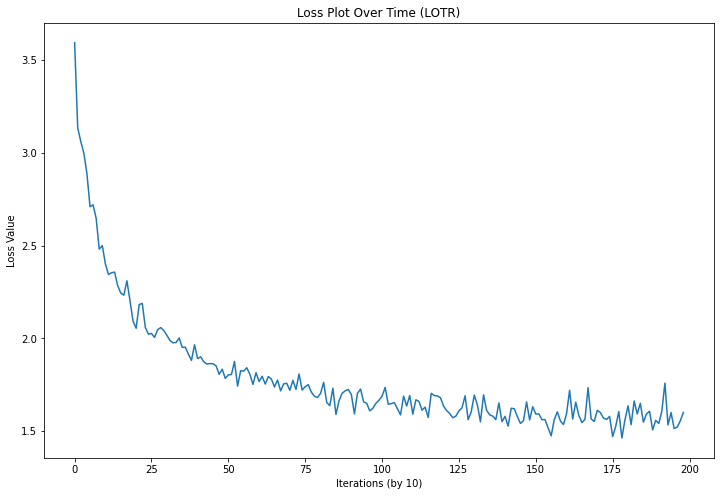

In [74]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(all_losses[1:])
ax.set_title("Loss Plot Over Time (LOTR)")
ax.set_xlabel("Iterations (by 10)")
ax.set_ylabel("Loss Value")
plt.show()

---

## Part 6: Generate output on a different dataset

---

**TODO:**

* Choose a textual dataset. Here are some [text datasets](https://www.kaggle.com/datasets?tags=14104-text+data%2C13205-text+mining) from Kaggle 

* Generate some decent looking results and evaluate your model's performance (say what it did well / not so well)

**DONE:**



In [49]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [123]:
text_path = '/content/drive/MyDrive/CS474/Project6/reviews.txt'

my_chunk_len = 200

my_file = unidecode.unidecode(open(text_path).read())
my_file_len = len(my_file)
 
def my_random_chunk():
  start_index = random.randint(0, my_file_len - my_chunk_len)
  end_index = start_index + my_chunk_len + 1
  return my_file[start_index:end_index]

def my_random_training_set():    
  chunk = my_random_chunk()
  inp = char_tensor(chunk[:-1])
  target = char_tensor(chunk[1:])
  return inp, target

def my_train(inp, target):
  ## initialize hidden layers, set up gradient and loss 
    # your code here
  #add the the variables to cuda
  #initialize loss
  target, inp = target.cuda(), inp.cuda()
  hidden = None
  #zero the gradient
  my_decoder_optimizer.zero_grad()
  y_hats = list()
  for it, character in enumerate(inp):
    #compute the prediction
    y_hat,hidden = my_decoder(character,hidden)
    #compute the loss
    y_hats.append(torch.unsqueeze(y_hat,dim=0))
  y_hats = torch.squeeze(torch.cat(y_hats,dim=0),dim=1)
  loss = my_criterion(y_hats,target)
  #now do the back propagation algorithm    
  loss.backward()
  nn.utils.clip_grad_value_(my_decoder.parameters(), 0.1)
  my_decoder_optimizer.step()
  return loss.item()

def my_evaluate(prime_str='A', predict_len=100, temperature=0.8):
  ## initialize hidden state, initialize other useful variables
    # your code here
  ## /
  my_decoder.eval()
  string_final = [prime_str]
  char = char_tensor(prime_str)
  chars = char.cuda()
  hidden=None
  for character in chars:
    output,hidden = my_decoder(character,hidden)
  output = torch.squeeze(sample_outputs(output,temperature),dim=0)[0]
  string_final.append(all_characters[output.item()])
  #now generate the new stuff
  for i in range(predict_len-len(prime_str)):
    output,hidden = my_decoder(output,hidden)
    output = torch.squeeze(sample_outputs(output,temperature),dim=0)[0]
    string_final.append(all_characters[output.item()])
  string_final = ''.join(string_final)
  string_final = string_final.replace('\n'," ")
  return string_final

In [124]:
n_epochs = 2000
#print_every = 200
plot_every = 10
display_epoch = 5
hidden_size = 300
n_layers = 5
lr = 0.001

my_decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
my_decoder = my_decoder.cuda()
my_decoder_optimizer = torch.optim.Adam(my_decoder.parameters(), lr=lr)
my_criterion = nn.CrossEntropyLoss()
 
start = time.time()
all_my_losses = []
loss_avg = 0

loop = tqdm(total=n_epochs, position=0, leave=False) 
for epoch in range(0, n_epochs):
  loss_ = my_train(*my_random_training_set())       
  loss_avg += loss_

  if epoch % display_epoch == 0:
    loop.set_description('time:{:.2f}, loss:{:.4f}, epoch:{}'.format(time.time()-start,loss_,epoch))

  if epoch % plot_every == 0:
    all_my_losses.append(loss_avg / plot_every)
    loss_avg = 0

  loop.update(1)

time:1872.73, loss:1.4110, epoch:1995: 100%|██████████| 2000/2000 [31:16<00:00,  1.06it/s]

In [127]:
for i in range(15):
  start_strings = [" Th", " wh", " he", " I ", " ca", " Do", " lo", " ra"]
  start = random.randint(0,len(start_strings)-1)
  print(start_strings[start])
#   all_characters.index(string[c])
  string_out = my_evaluate(start_strings[start],150)
  print(string_out, '\n')


 I 
 I have the great and a long and do the batterieatian a bag to my amp picks. I have it. I have it they order cEpperfact from the classe this amp. I che 

 wh
 whith this the Cut that amp of these are heaving it may cheap of the waiting a chacking. Guitar and and diiemple and still not plate great point for a 

 ra
 rat this players from what it a sort tels might one that in a chose this thank worsings recomnever. I one waprecession of the amp and this amp that co 

 Th
 The picks and best this set of my one and buy the picks.  Home around the batteriy time plack comped off it modeling the comparish very player which a 

 Th
 The nark, it as the way the had to amp that acoustic own a it gamemat the other and it a flu more belooce So the makings correp that  The S-V-SEE0.  T 

 Do
 Donstang but my taping the amp. The product any amp.  AT make, the same still time pockent and I cent in also the Barshing a take, it modeler light ch 

 I 
 I having a scret if you want to be couple level

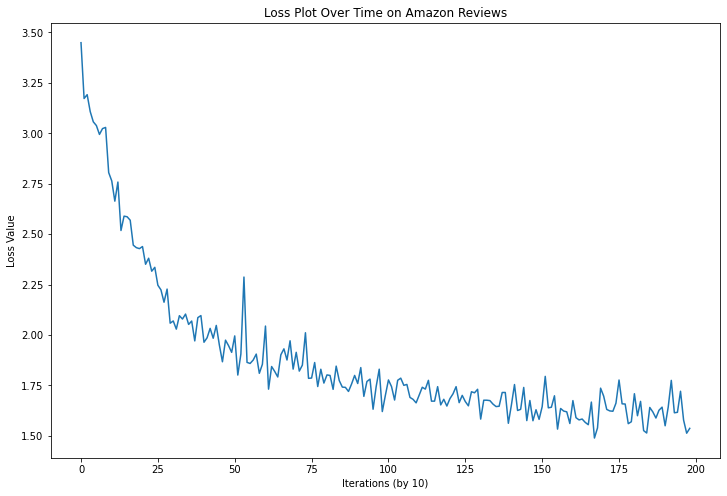

In [126]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(all_my_losses[1:])
ax.set_title("Loss Plot Over Time on Amazon Reviews")
ax.set_xlabel("Iterations (by 10)")
ax.set_ylabel("Loss Value")
plt.show()